## Prepare Notebook

In [1]:
import numpy as np
import scipy.stats as ss
import pandas as pd
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
tfd = tfp.distributions

# Data Viz. 
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

# Get TensorFlow version.
print(f'TnesorFlow version: {tf.__version__}')
print(f'TnesorFlow Probability version: {tfp.__version__}')

TnesorFlow version: 2.3.1
TnesorFlow Probability version: 0.11.1


## Generate Data

In [2]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]
# Size of dataset
size = 100
# Predictor variable
x1 = np.random.randn(size)
x2 = np.random.randn(size) * 0.2
# Simulate outcome variable
y = alpha + beta[0] * x1 + beta[1] * x2 + np.random.randn(size) * sigma

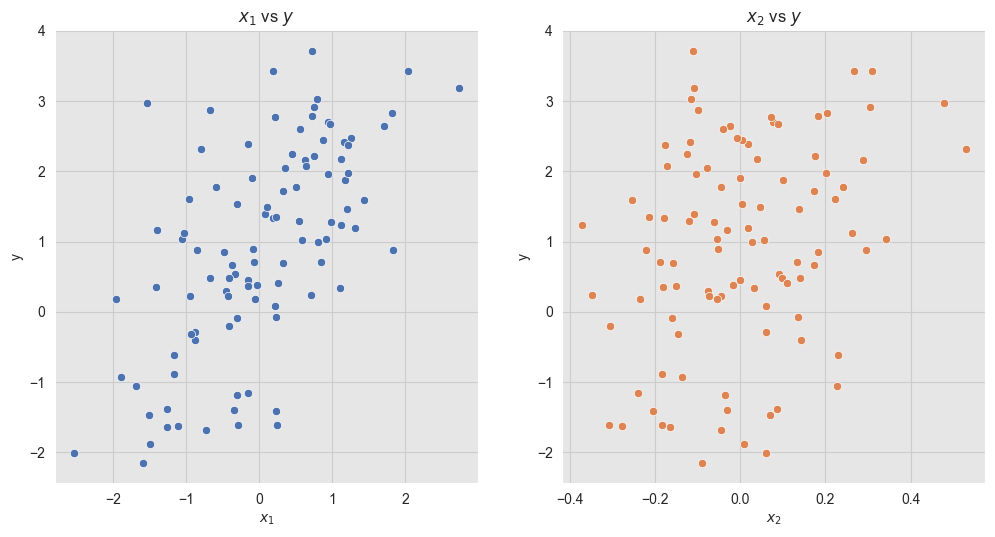

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=2)
sns.scatterplot(x=x1, y=y, color=sns_c[0], ax=ax[0])
sns.scatterplot(x=x2, y=y, color=sns_c[1], ax=ax[1])
ax[0].set(title='$x_1$ vs $y$', xlabel='$x_1$', ylabel='y')
ax[1].set(title='$x_2$ vs $y$', xlabel='$x_2$', ylabel='y');

## Define Model

$$y = \alpha + \beta x + \varepsilon$$

In [4]:
dtype = 'float32'

x = np.stack([x1, x2], axis=1)
x = tf.convert_to_tensor(x, dtype=dtype)

y = tf.convert_to_tensor(y, dtype=dtype)
y = tf.reshape(y, (-1, 1))

In [5]:
jds_ab = tfd.JointDistributionNamedAutoBatched(dict(

    sigma=tfd.HalfNormal(scale=[tf.cast(1.0, dtype)]),

    alpha=tfd.Normal(
        loc=[tf.cast(0.0, dtype)], 
        scale=[tf.cast(10.0, dtype)]
    ),

    beta=tfd.Normal(
        loc=[[tf.cast(0.0, dtype)], [tf.cast(0.0, dtype)]], 
        scale=[[tf.cast(10.0, dtype)], [tf.cast(10.0, dtype)]]
    ),

    y=lambda beta, alpha, sigma: 
        tfd.Normal(
            loc=tf.linalg.matmul(x, beta) + alpha, 
            scale=sigma
        ) 
))

## Fit Model

In [6]:
def target_log_prob_fn(beta=beta, alpha=alpha, sigma=sigma):
    return jds_ab.log_prob(beta=beta, alpha=alpha, sigma=sigma, y=y)

In [7]:
# Size of each chain.
num_results = int(1e4)
# Burn-in steps.
num_burnin_steps = int(1e3)
# Hamiltonian Monte Carlo transition kernel. 
# In TFP a TransitionKernel returns a new state given some old state.
hcm_kernel  = tfp.mcmc.HamiltonianMonteCarlo(
  target_log_prob_fn=target_log_prob_fn,
  step_size=1.0,
  num_leapfrog_steps=3
  
)
# This adapts the inner kernel's step_size.
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
  inner_kernel = hcm_kernel,
  num_adaptation_steps=int(num_burnin_steps * 0.8)
)
# Run the chain (with burn-in).
@tf.function
def run_chain():
  # Run the chain (with burn-in). 
  # Implements MCMC via repeated TransitionKernel steps.
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=[
          tf.convert_to_tensor([[1.0], [1.0]], dtype=dtype),
          tf.convert_to_tensor([1.0], dtype=dtype), 
          tf.convert_to_tensor([1.0], dtype=dtype)
      ],
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted
    )
  return samples

In [8]:
# Set number of chains. 
num_chains = 5
# Run sampling. 
chains = [run_chain() for i in range(num_chains)]

## Visualize Posterior Distributions

In [9]:
chains_t = list(map(list, zip(*chains)))

chains_samples = [tf.squeeze(tf.concat(samples, axis=0)) for samples in chains_t]

In [10]:
chains_df = pd.concat(
    objs=[pd.DataFrame(samples.numpy()) for samples in chains_samples], 
    axis=1
)

params = ['beta_0', 'beta_1', 'alpha', 'sigma']
chains_df.columns = params

chains_df = chains_df \
    .assign(
        sample_id=lambda x: range(x.shape[0]), 
        chain_sample_id=lambda x: x['sample_id'] % num_results,
        chain_id=lambda x: (x['sample_id'] / num_results).astype(int) + 1
    ) \
    .assign(chain_id=lambda x: 'c_' + x['chain_id'].astype(str)) \
    

chains_df.head()

beta_0    beta_1     alpha     sigma  sample_id  chain_sample_id chain_id
0  0.893328  2.780258  0.737689  1.090648          0                0      c_1
1  0.893328  2.780258  0.737689  1.090648          1                1      c_1
2  1.078044  2.543808  1.119716  1.184439          2                2      c_1
3  0.831845  2.832933  0.723859  1.002322          3                3      c_1
4  0.831845  2.832933  0.723859  1.002322          4                4      c_1

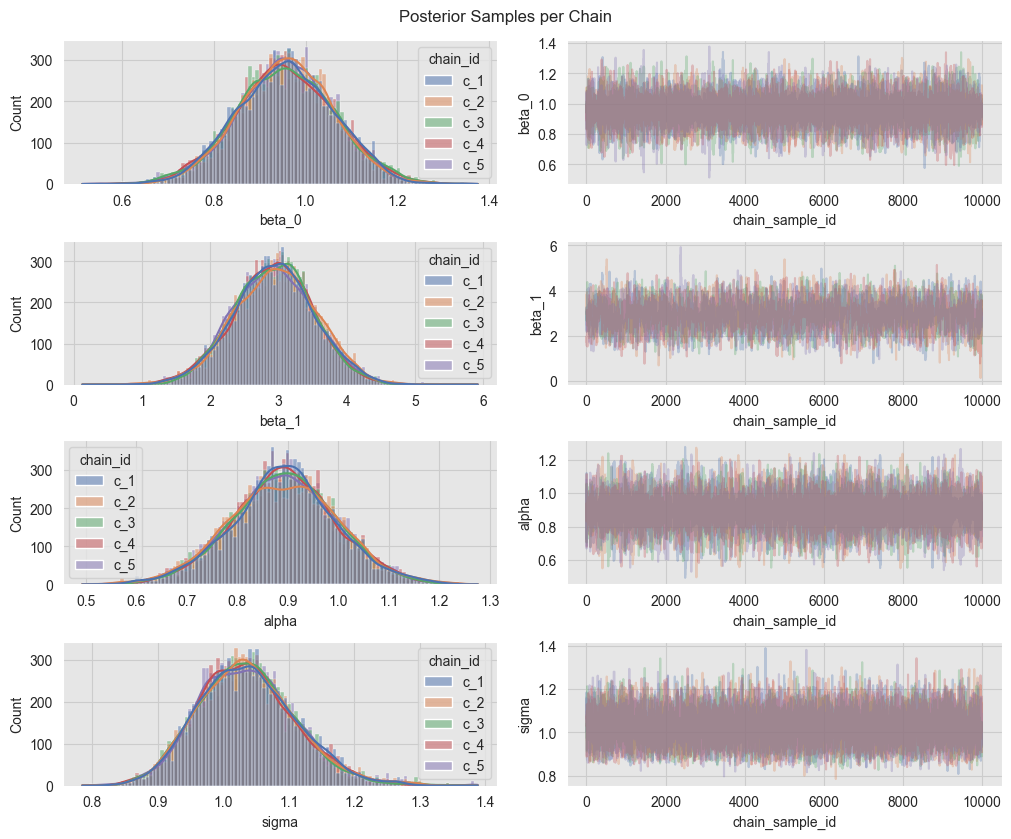

In [16]:
fig, axes = plt.subplots(nrows=len(params), ncols=2, figsize=(10, 8), constrained_layout=True)

for i, param in enumerate(params):
    sns.histplot(x=param, data=chains_df, hue='chain_id', kde=True, ax=axes[i][0])
    sns.lineplot(x='chain_sample_id', y=param, data=chains_df, hue='chain_id', alpha=0.3, legend=False, ax=axes[i][1])

fig.suptitle('Posterior Samples per Chain', y=1.03);

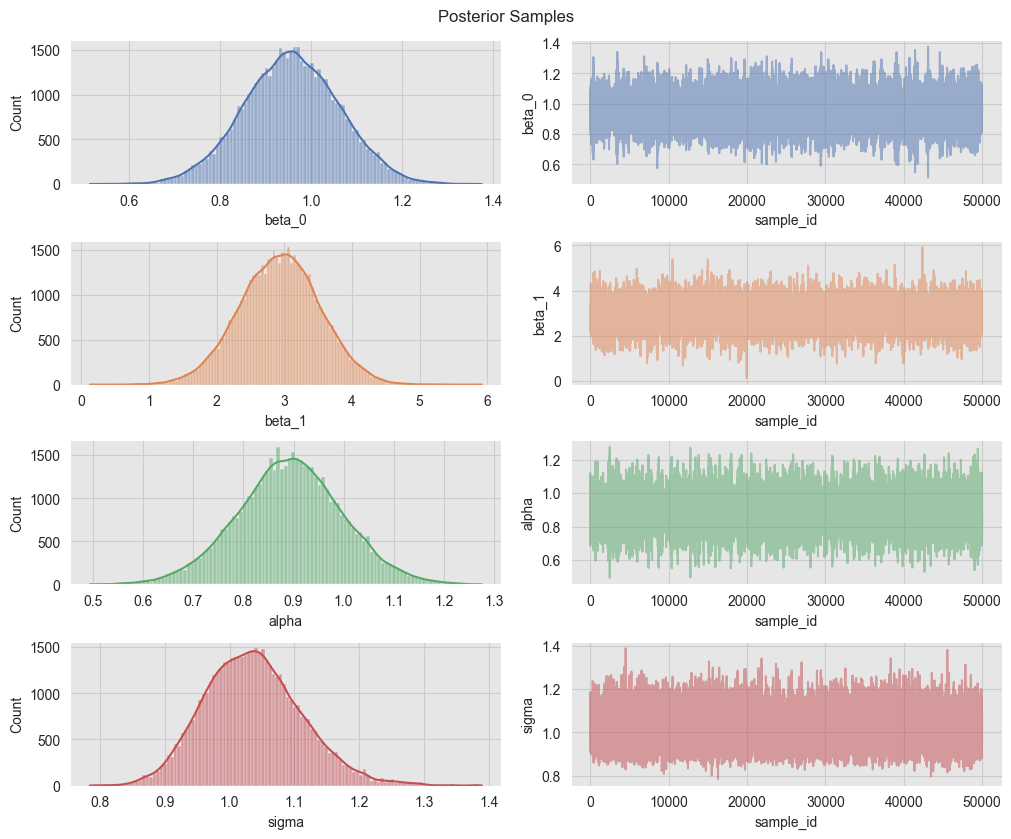

In [17]:
fig, axes = plt.subplots(nrows=len(params), ncols=2, figsize=(10, 8), constrained_layout=True)

for i, param in enumerate(params):
    sns.histplot(x=param, data=chains_df, color=sns_c[i], kde=True, ax=axes[i][0])
    sns.lineplot(x='sample_id', y=param, data=chains_df, color=sns_c[i], alpha=0.5, ax=axes[i][1])

fig.suptitle('Posterior Samples', y=1.03);

## Generate Predictions

In [14]:
mu_posterior_samples = tf.linalg.matmul(tf.reshape(chains_samples[1], (-1, 1)), tf.ones(shape=(1, x.shape[0]))) \
    + tf.linalg.matmul(chains_samples[0], tf.transpose(x)) 

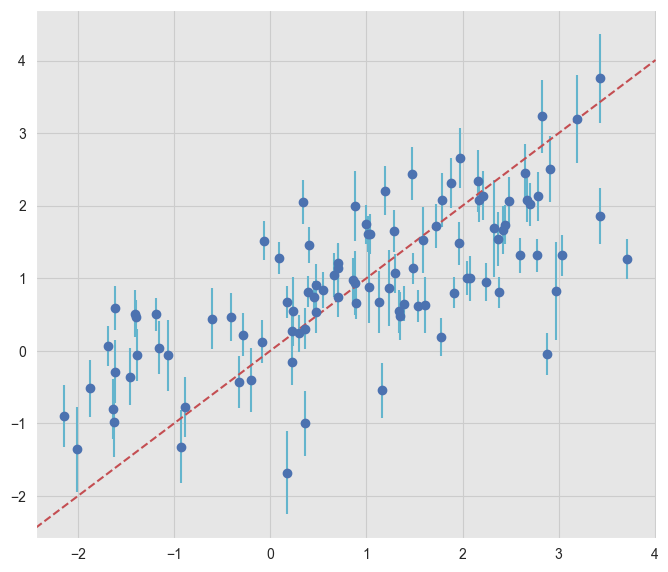

In [15]:
mu_posterior_mean = tf.math.reduce_mean(mu_posterior_samples, axis=0).numpy()
mu_posterior_std = tf.math.reduce_std(mu_posterior_samples, axis=0).numpy()

fig, ax = plt.subplots(figsize=(8, 7)) 
ax.errorbar(
    x=tf.squeeze(y).numpy(), 
    y=mu_posterior_mean, 
    yerr=2*mu_posterior_std,
    fmt='o',
    ecolor=sns_c[9]
)
ax.axline(xy1=(0,0), slope=1, linestyle='--', color=sns_c[3]);